# Using Reinforcement Learning to play the Freeway game

**In this project we propose to apply Reinforcemente Learning control methods to learn how to play the Freeway Game.**  




***Group members:*** *Aline Gabriel de Almeida, Dionisius Oliveira Mayr (229060), Leonardo de Oliveira Ramos (171941), Marianna de Pinho Severo (264960), Victor Jesús Sotelo Chico (265173)*

## 1. The Freeway Atari game

<img src="img/Freeway_logo.png" width="60%">

The game is a challenge where a chicken need to be guided across ten lanes of freeway traffic. She can be moved ahead (**up**), back (**down**) or don't move (**stay**).  
<br>
Each time the chicken is guided successfully across the freeway, the score increases by 1 and there are 2 minutes and 16 seconds in each round of the game. The most points, the better.  
<br>
To do so we will use an API called **Gym Retro**, that enables us turn classic video games into Gym environments.  


In [1]:
# ---------- Install the dependencies ----------

#!pip install gym
#!pip install gym[atari]

In [2]:
# ---------- Libraries ----------

#!pip install dill

import sys
sys.path.append('../')  # Enable importing from `src` folder

%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer

def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [3]:
import importlib
importlib.reload(aux_plots)

<module 'src.aux_plots' from '/home/aline/Documents/GitHub/FreewayGame/aline.almeida/src/aux_plots.py'>

## 2. The Reinforcement Learning problem adressed

### 2.1 Representing the states of the game

In gym, the RAM is represented as an 128-element array, where each element in the array can range from 0 to 255.
This would generate a huge space state that we are not able to deal with.

In order to reduce the space state to be used, we filtered some features from the RAM of the game. Specifically the array position and the features descriptions are:
- **14**: The chicken Y-position value
- **16**: Indicates if there was a collision
- **108 to 117**: Indicate the cars X-coordinates in each lane. 


In [4]:
# ---------- RAM mask for the selected features ----------

RAM_mask = [
      14  # The chicken Y-position value
    , 16  # Indicates if there was a collision
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Indicate the cars X-coordinates in each lane.
]

In order to reduce even more our space state representation, we restricted the chicken's field of view assuming that the cars that are next to the chicken have valuable information for the agent to choose the best action to take, while the cars that are far from the chicken have low influence in the action decision process therefore they can be ignored.   
<br>
Also, we consider that it's impportant and sufficient to the agent to know if there was a collision, but the specific lane were the collision occured can be ignored.

In [5]:
# ---------- Restricting the chicken's field of view ----------

def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position 
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 19 or ob[b] > 79:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space 
            ob[b] = ob[b] // 3

    return ob

### 2.2 The environment 

In this project we will use the **Open AI Gym** toolkit to work out our reinforcement learning algorithms and test our solutions.  
<br>
The environment used is the **Freeway-ram-v0**. 

In [6]:
# ---------- Gym Freeway-ram-v4 environment ----------

env, initial_state = environment.get_env()

print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Action Space: Discrete(3)
Observation Space: Box(0, 255, (128,), uint8)


### 2.3 The Reward Function

We defined five conditions were the agent can get a reward: 
- If the chicken cross the 10 lanes; This is our fundamental goal and should be encouraged.
- If the chicken collide; As the collisions can delay the chicken to cross the lanes, it can be discouraged.
- Each one of the agent's three actions can be rewarded according to how much they can help the chicken to cross all the lanes and doing so we can hopefully accelerate the conversion of the algorithms; 

In [7]:
# ---------- Rewards ----------

def reward_policy(reward, ob, action):
    if reward == 1:    # Cross all the lanes
        reward = reward_policy.REWARD_IF_CROSS
    
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
       
    elif action == 0:  # don't move (still)
        reward = reward_policy.REWARD_IF_STILL
        
    elif action == 1:  # Move ahead (up)
        reward = reward_policy.REWARD_IF_FW
    
    elif action == 2:  # Move back (down)
        reward = reward_policy.REWARD_IF_BW

    return reward

### 2.4 Baseline agent

We defined our baseline result as the result obtained from an agent that always choose the action to move ahead (**up**).   <br>
The mean result our baseline agent gets is around 21.5 points.

In [8]:
# ---------- Running the baseline agent ----------

# baseline_scores = environment.run(agents.Baseline, render=False, n_runs=100, verbose=False)
#
# with open("baseline_scores.txt", "w") as f:
#     for item in baseline_scores:
#         f.write("%s\n" % item)

In [9]:
with open("baseline_scores.txt") as f:
    baseline_scores = [int(x) for x in  f.read().splitlines()]

In [10]:
# Mean score of the baseline agent
baseline_mean_score = sum(baseline_scores) / len(baseline_scores) 
print("Baseline mean score:", baseline_mean_score)

Baseline mean score: 21.48


## 3. Q-Learning

The Q-learning algorithm receives the $\gamma$ and the $N0$ parameters.  
<br>
$\gamma$ is the discount factor; This parameters determines the importance of future rewards. A value of 0 makes the agent short-sighned by only considering current rewards, while a factor approaching 1 will make it strive for a long term reward.  
<br>
The $N0$ parameter is used to define the agent's exploration rate $\epsilon$, where $\epsilon = N0/(N0+n)$ and $n$ is the number of visits in the states.  
<br>
In the algorithm, the action-value function is initialized to zero. Then, at each time $t$ the agent selects an action $a_t$, observes a reward $r_t$, enters a new state $s_{s+1}$, and $Q$ is updated:

$Q_{new}(s_t, a_t) :=  Q(s_t, a_t)+\alpha (r_t + \gamma.max_aQ(s_{t+1},a)-Q(s_t, a_t))$

The learning rate $\alpha$ is defined as $\alpha = 1/Nsa$, where $Nsa$ is the number of times that the specific state-action pair has already occured.

### 3.1. Influence of the number of actions

As the goal of the game is to cross all the lanes, we propose that it would be enought if the chicken use just the two actions move **up** or **stay** and never move **down**.
<br>
In order to test our hypothesis, we ran the agent using 3 and 2 actions.  


#### 3.1.1) Agent with 2 actions available (*up* or *stay*):

In [146]:
# ---------- Agent with 2 actions available (up or stay) ----------

# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 7000

In [147]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act = []
# total_rewards_2act = []

In [148]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#  
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act.append(score)
#     total_rewards_2act.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_2act, total_reward, score)

In [149]:
# with open("QL/QL_scores_2act.txt", "w") as f:
#    for item in scores_2act:
#        f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_2act.txt", "w") as f:
#    for item in total_rewards_2act:
#        f.write("%s\n" % item)

In [150]:
with open("QL/QL_scores_2act.txt") as f:
   scores_2act = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act.txt") as f:
   total_rewards_2act = [int(x) for x in  f.read().splitlines()]

#### 3.1.2) Agent with 3 actions available (*up*, *stay*, or *down*):

In [151]:
# ---------- Agent with 3 actions available (up, stay or down) ----------

# GAMMA = 0.99
# AVAILABLE_ACTIONS = 3
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
# reward_policy.REWARD_IF_BW = -9
#
# n_runs = 4000

In [152]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_3act = []
# total_rewards_3act = []

In [153]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#  
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
3
#     scores_3act.append(score)
#     total_rewards_3act.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_3act, total_reward, score)

3

In [154]:
# with open("QL/QL_scores_3act.txt", "w") as f:
#    for item in scores_3act:
#        f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_3act.txt", "w") as f:
#    for item in total_rewards_3act:
#        f.write("%s\n" % item)

In [155]:
with open("QL/QL_scores_3act.txt") as f:
   scores_3act = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_3act.txt") as f:
   total_rewards_3act = [int(x) for x in  f.read().splitlines()]

#### 3.1.3) Results got from agents with different number of actions available:

As we can see from the results show in the plots below, the agent with 2 actions available performs better than the agent with 3 actions available, confirming our hypothesis.  
<br>
Below the plots are showing the score and the total rewards got using the two agents. 

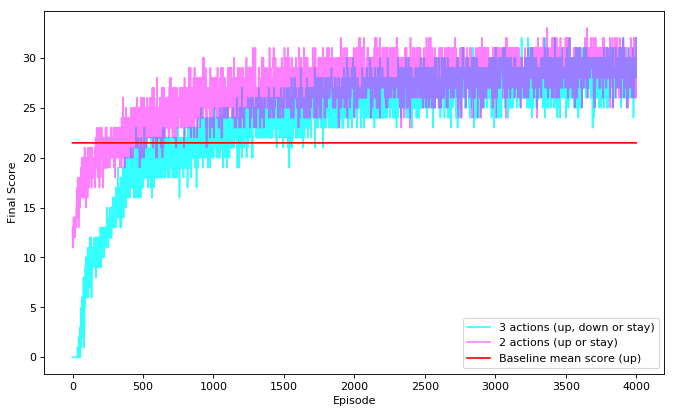

In [156]:
# ---------- Scores of the agent with 2 and 3 actions ----------

baseline = [baseline_mean_score for i in range(4000)]
aux_plots.plot_3scores(scores_3act[:4000], scores_2act[:4000], baseline[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)", "Baseline mean score (up)")

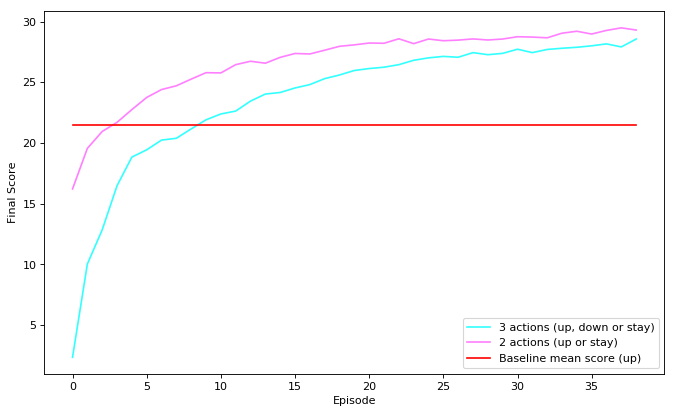

In [157]:
# ---------- Moving average for the scores of the agent with 2 and 3 actions ----------

import statistics 
from statistics import mean

s1 = scores_3act[:4000]
s2 = scores_2act[:4000]
s3 = baseline[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (up, down or stay)", "2 actions (up or stay)", "Baseline mean score (up)")

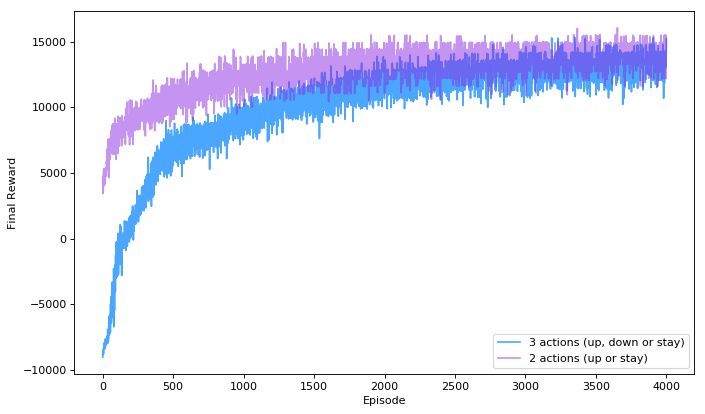

In [158]:
# ---------- Rewards of the agent with 2 and 3 actions ----------

aux_plots.plot_2rewards(total_rewards_3act[:4000], total_rewards_2act[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)")

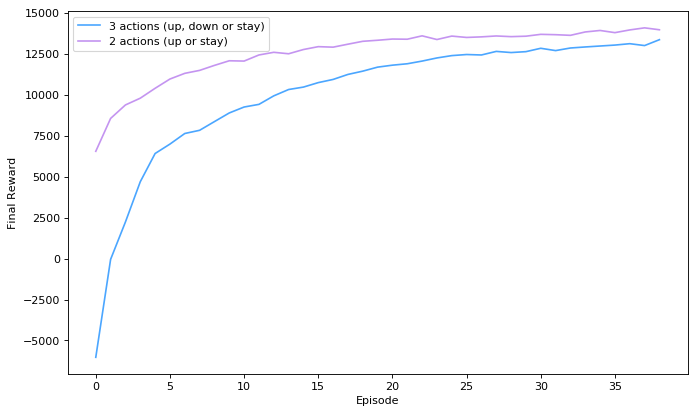

In [159]:
# ---------- Moving average for the rewards of the agent with 2 and 3 actions ----------


s1 = total_rewards_3act[:4000]
s2 = total_rewards_2act[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_2rewards(s1_avg100, s2_avg100, "3 actions (up, down or stay)", "2 actions (up or stay)")

### 3.2. Influence of the reward values

In order to investigate the influence of the reward values in the agent behavior, we ran the algorithm using three different set of reward values.  
<br>
**R1:** Positive rewards for crossing: it offered a sparse reward to the agent: +1 if the chicken cross all the lanes.  
<br>
**R2:** Positive rewards for crossing and negative reward for colliding: it given +1 for crossing all the lanes and -1 if the chicken collide. Thus, we expect the agent to be encouraged to cross the lanes (positive reward) and to avoid collisions (negative reward).  
<br>
**R3:** Huge positive reward for crossing and negative reward for colliding or staying in the same position: it increased the reward for crossing all the lanes to +500 and give -10 when the chicken collide. It also gives a negative reward of -1 when the agent decide to **still**. Thus we expect the chicken to be incentivate to cross the lanes more rapidilly and increase the score.

#### 3.2.1) Rewards: $+1$ if cross all the lanes

In [160]:
# # ---------- R1: Crossing the lanes +1 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 1
# reward_policy.REWARD_IF_COLISION = 0
# reward_policy.REWARD_IF_STILL = 0
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [161]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act_sparseR_cross = []
# total_rewards_2act_sparseR_cross = []

In [162]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
# 
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act_sparseR_cross.append(score)
#     total_rewards_2act_sparseR_cross.append(total_reward)
#   
#     if i % 100 == 0:
#         print_result(i, scores_2act_sparseR_cross, total_reward, score)

In [163]:
# with open("QL/QL_scores_2act_sparseR_cross.txt", "w") as f:
#     for item in scores_2act_sparseR_cross: 
#         f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_2act_sparseR_cross.txt", "w") as f:
#     for item in total_rewards_2act_sparseR_cross:
#         f.write("%s\n" % item)

In [164]:
with open("QL/QL_scores_2act_sparseR_cross.txt") as f:
   scores_2act_sparseR_cross = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act_sparseR_cross.txt") as f:
   total_rewards_2act_sparseR_cross = [int(x) for x in  f.read().splitlines()]

#### 3.2.2) Rewards: $+1$ if cross all the lanes, $-1$ if collide

In [165]:
# # ---------- R2: Crossing the lanes +1 and colision -1 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 1
# reward_policy.REWARD_IF_COLISION = -1
# reward_policy.REWARD_IF_STILL = 0
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [166]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act_sparseR = []
# total_rewards_2act_sparseR = []

In [167]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#   
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act_sparseR.append(score)
#     total_rewards_2act_sparseR.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_2act_sparseR, total_reward, score)

In [168]:
# with open("QL/QL_scores_2act_sparseR.txt", "w") as f:
#     for item in scores_2act_sparseR: 
#         f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_2act_sparseR.txt", "w") as f:
#     for item in total_rewards_2act_sparseR:
#         f.write("%s\n" % item)

In [169]:
with open("QL/QL_scores_2act_sparseR.txt") as f:
   scores_2act_sparseR = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act_sparseR.txt") as f:
   total_rewards_2act_sparseR = [int(x) for x in  f.read().splitlines()]

#### 3.2.3) Results got from agents receiving different reward values:

As we can see in the plots below, the agent that receives a sparse reward of +1 only when cross all the lanes and -1 if collide performs worse than the second agent after about 1k iterations. As the second agent has a higher reward for crossing the lanes and also is discouraged to still or to collide, it learns much faster how to achieve higher scores, confirming our proposed hypothesis.  
<br>
Below the plots are showing the score and the total rewards got using the two agents. 

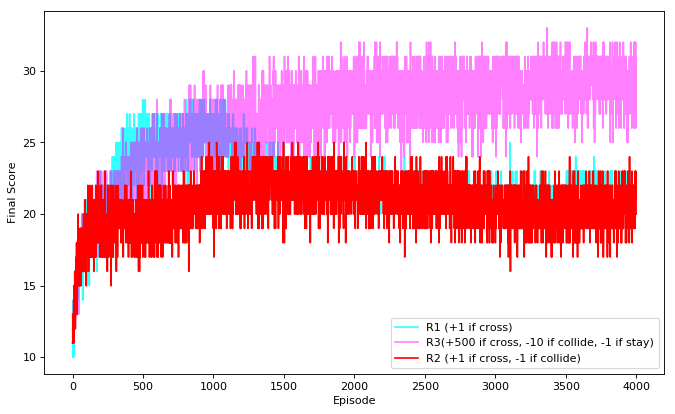

In [170]:
# ---------- Scores of the agent with different rewards ----------

aux_plots.plot_3scores(scores_2act_sparseR[:4000], scores_2act[:4000], scores_2act_sparseR_cross[:4000], "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

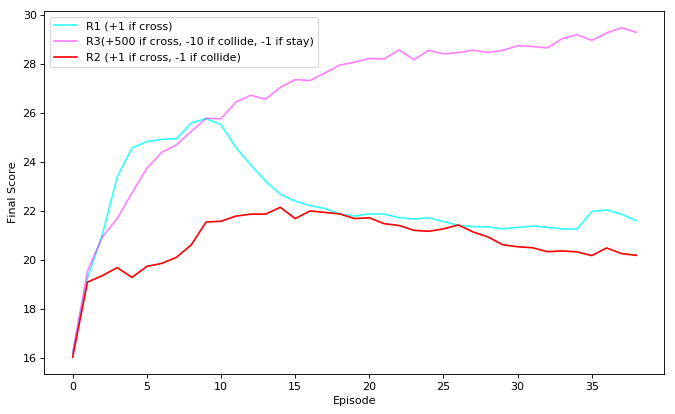

In [171]:
# ---------- Moving average for the scores of the agent with different rewards ----------

from statistics import mean

s1 = scores_2act_sparseR[:4000]
s2 = scores_2act[:4000]
s3 = scores_2act_sparseR_cross[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

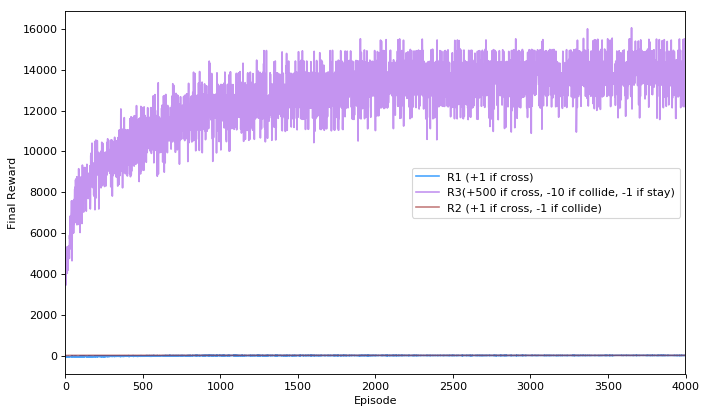

In [172]:
# ---------- Rewards of the agent with different rewards ----------

aux_plots.plot_3rewards(total_rewards_2act_sparseR[:4000], total_rewards_2act[:4000], scores_2act_sparseR_cross[:4000], "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

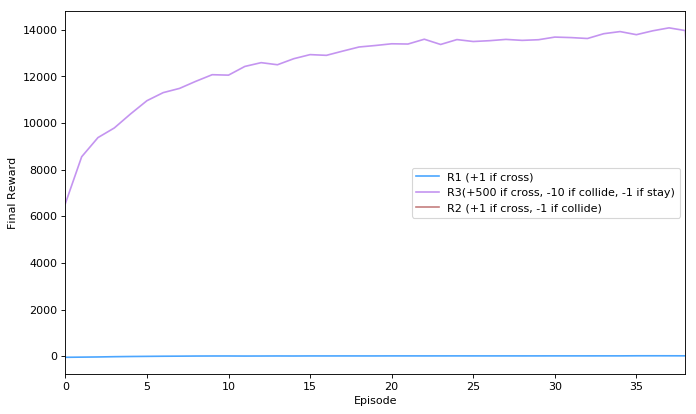

In [173]:
# ---------- Moving average for the total rewards of the agent with different rewards  ----------

from statistics import mean

s1 = total_rewards_2act_sparseR[:4000]
s2 = total_rewards_2act[:4000]
s3 = total_rewards_2act_sparseR_cross[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
        
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s2_avg100.append(value)
        
aux_plots.plot_3rewards(s1_avg100, s2_avg100, s3_avg100, "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

### 3.3. Influence of the $𝑁0$ parameter that is used to define the agent's exploration rate  𝜖

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  
The $𝑁0$ parameter is used to define the agent's exploration rate $\epsilon$ , where  $\epsilon = N0/(N0+n)$ and $n$ is the number of times that state has been visited.  
<br>
We used a very small value of $N0$ (0.001) so we can see how well the agent performs if it almost don't explore at all and also used $N0$ = 2.5 and $N0$ = 5.0 so we can see how the exploration rate impact the agent behavior.

#### 3.3.1) $N0$ = 0.001

In [174]:
# # ---------- Agent with N0=0.001 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 =  0.001
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 7000

In [175]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act_N0_0 = []
# total_rewards_2act_N0_0 = []

In [176]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#   
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act_N0_0.append(score)
#     total_rewards_2act_N0_0.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_2act_N0_0, total_reward, score)

In [177]:
# with open("QL/QL_scores_2act_N0_0.txt", "w") as f:
#    for item in scores_2act_N0_0:
#        f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_2act_N0_0.txt", "w") as f:
#    for item in total_rewards_2act_N0_0:
#        f.write("%s\n" % item)

In [178]:
with open("QL/QL_scores_2act_N0_0.txt") as f:
   scores_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act_N0_0.txt") as f:
   total_rewards_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

#### 3.3.2) $N0$ = 5

In [179]:
# # ---------- Agent with N0=5 ----------

# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 =  5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 7000

In [180]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act_N0_5 = []
# total_rewards_2act_N0_5 = []

In [181]:
# %%time

# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#   
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act_N0_5.append(score)
#     total_rewards_2act_N0_5.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_2act_N0_5, total_reward, score)

In [182]:
# with open("QL/QL_scores_2act_N0_5.txt", "w") as f:
#    for item in scores_2act_N0_5:
#        f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_2act_N0_5.txt", "w") as f:
#    for item in total_rewards_2act_N0_5:
#        f.write("%s\n" % item)

In [183]:
with open("QL/QL_scores_2act_N0_5.txt") as f:
   scores_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act_N0_5.txt") as f:
   total_rewards_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

#### 3.3.3) Results got using different $N0$ values:

......................

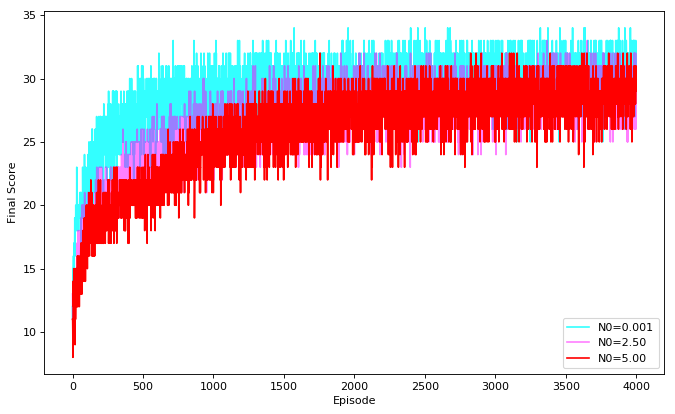

In [184]:
# ---------- Scores of the agent with N0=0.001, N0=2.5 and N0=5 ----------
aux_plots.plot_3scores(scores_2act_N0_0[:4000], scores_2act[:4000], scores_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

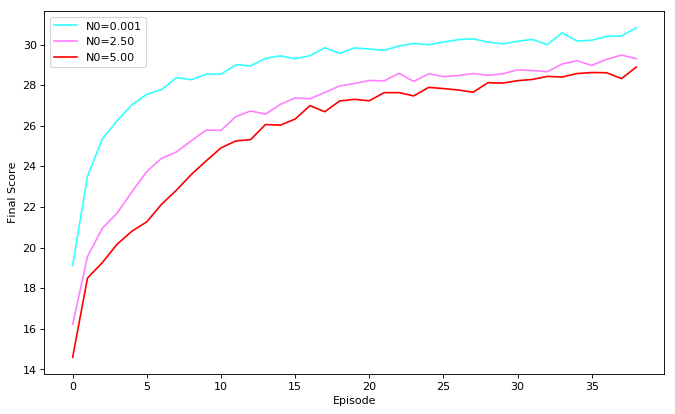

In [185]:
# ---------- Moving average of the scores of the agent with N0=0.001, N0=2.5 and N0=5 ----------

from statistics import mean

s1 = scores_2act_N0_0[:4000]
s2 = scores_2act[:4000]
s3 = scores_2act_N0_5[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "N0=0.001", "N0=2.50", "N0=5.00")

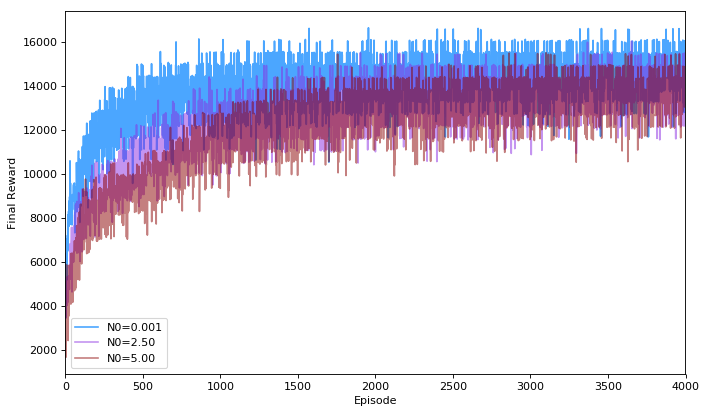

In [186]:
# ---------- Rewards of the agent with N0=0.001, N0=2.5 and N0=5 ----------

aux_plots.plot_3rewards(total_rewards_2act_N0_0[:4000], total_rewards_2act[:4000], total_rewards_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

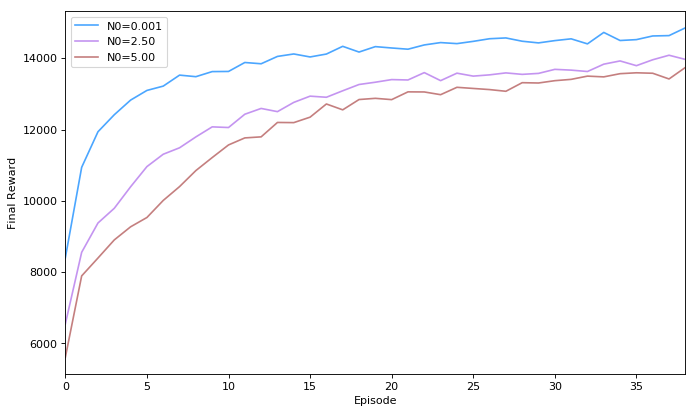

In [187]:
# ---------- Moving average for the total rewards of the agent with N0=0.001, N0=2.5 and N0=5 ----------

from statistics import mean

s1 = total_rewards_2act_N0_0[:4000]
s2 = total_rewards_2act[:4000]
s3 = total_rewards_2act_N0_5[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)

s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
        
aux_plots.plot_3rewards(s1_avg100, s2_avg100, s3_avg100, "N0=0.001", "N0=2.50", "N0=5.00")

### 3.4. Influence of the discount factor

The discount factor $\gamma$ essentially determines how much the agent cares about rewards in the distant future relative to those in the immediate future.  
<br>
If $\gamma$=0, the agent will be completelly myopic and only learn about actions that produce an immediate reward. If $\gamma$=1 the agent will evaluate each of its actions based on the sum of toital of all of its futures rewards.  
<br>
We used a $\gamma$ value very small (0.001) in order to make our agent short-sighned by only considering immediate rewards, and also used another two values of 2.5 and 5 to compare the results and see how they can impact the agent behavior. 

#### 3.4.1) $ɣ$ = 0.90

In [188]:
# # ---------- Agent with gamma=0.90 ----------
#
# GAMMA = 0.90
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [189]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act_gamma_0p9 = []
# total_rewards_2act_gamma_0p9 = []

In [190]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#   
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act_gamma_0p9.append(score)
#     total_rewards_2act_gamma_0p9.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_2act_gamma_0p9, total_reward, score)

In [191]:
# with open("QL/QL_scores_2act_gamma_0p9.txt", "w") as f:
#    for item in scores_2act_gamma_0p9:
#        f.write("%s\n" % item)
#
# with open("QL/QL_total_rewards_2act_gamma_0p9.txt", "w") as f:
#    for item in total_rewards_2act_gamma_0p9:
#        f.write("%s\n" % item)

In [192]:
with open("QL/QL_scores_2act_gamma_0p9.txt") as f:
   scores_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act_gamma_0p9.txt") as f:
   total_rewards_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

#### 3.4.2) $ɣ$ = 0.75

In [193]:
# # ---------- Agent with gamma=0.75 ----------
#
# GAMMA = 0.75
# AVAILABLE_ACTIONS = 2
# N0 =  2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [194]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_2act_gamma_0p75 = []
# total_rewards_2act_gamma_0p75 = []

In [195]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#   
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_2act_gamma_0p75.append(score)
#     total_rewards_2act_gamma_0p75.append(total_reward)
#    
#     if i % 100 == 0:
#         print_result(i, scores_2act_gamma_0p75, total_reward, score)

In [196]:
# with open("QL/QL_scores_2act_gamma_0p75.txt", "w") as f:
#    for item in scores_2act_gamma_0p75:
#        f.write("%s\n" % item)

# with open("QL/QL_total_rewards_2act_gamma_0p75.txt", "w") as f:
#    for item in total_rewards_2act_gamma_0p75:
#        f.write("%s\n" % item)

In [197]:
with open("QL/QL_scores_2act_gamma_0p75.txt") as f:
   scores_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act_gamma_0p75.txt") as f:
   total_rewards_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

#### 3.4.3) Results got using different $\gamma$ values:

..................

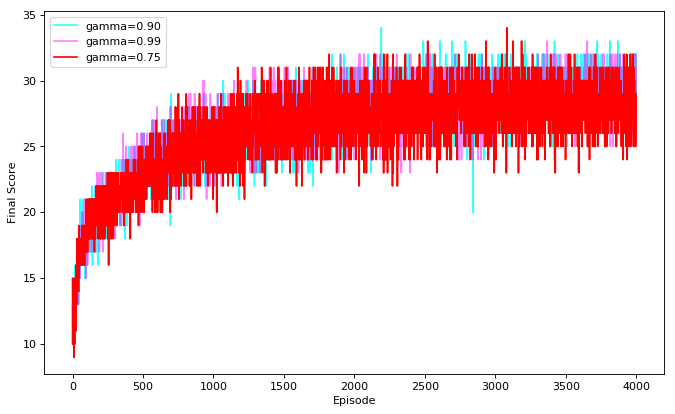

In [198]:
# ---------- Scores of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

aux_plots.plot_3scores(scores_2act_gamma_0p9[:4000], scores_2act[:4000], scores_2act_gamma_0p75[:4000], "gamma=0.90", "gamma=0.99", "gamma=0.75")

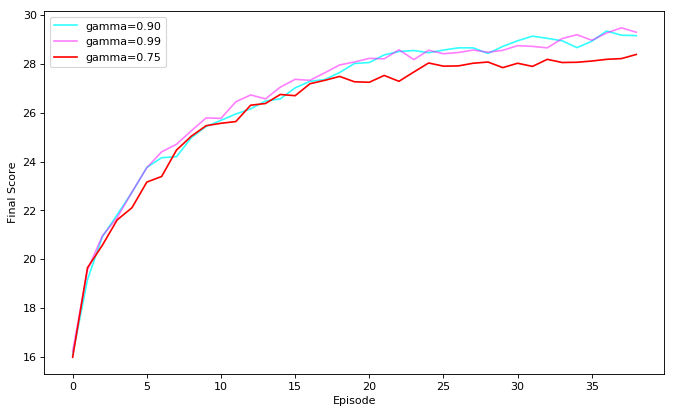

In [199]:
# ---------- Moving average for the scores of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

s1 = scores_2act_gamma_0p9[:4000]
s2 = scores_2act[:4000]
s3 = scores_2act_gamma_0p75[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "gamma=0.90", "gamma=0.99", "gamma=0.75")

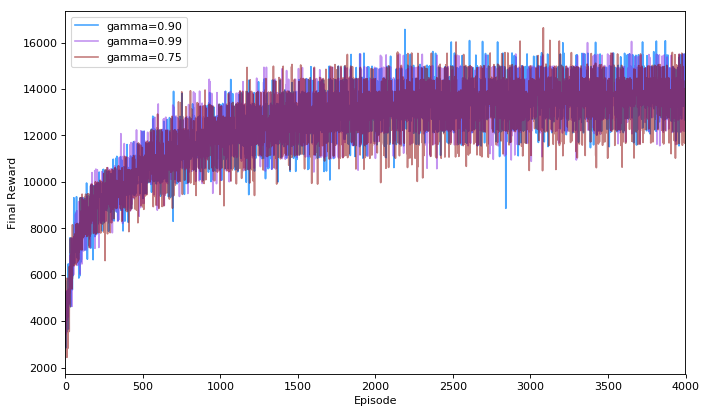

In [200]:
# ---------- Total rewards of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

aux_plots.plot_3rewards(total_rewards_2act_gamma_0p9[:4000], total_rewards_2act[:4000], total_rewards_2act_gamma_0p75[:4000], "gamma=0.90", "gamma=0.99", "gamma=0.75")

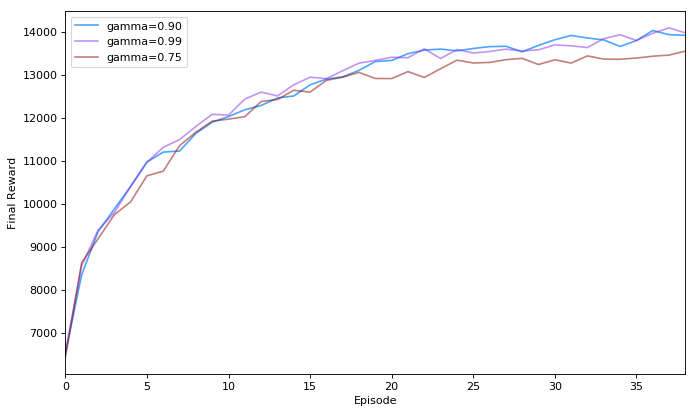

In [201]:
# ---------- Moving average for the total rewards of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

s1 = total_rewards_2act_gamma_0p9[:4000]
s2 = total_rewards_2act[:4000]
s3 = total_rewards_2act_gamma_0p75[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3rewards(s1_avg100, s2_avg100, s3_avg100, "gamma=0.90", "gamma=0.99", "gamma=0.75")

## 4) Monte Carlo Control

The Monte Carlo algorithm receives the $\gamma$ and the $N0$ parameters.  
<br>
$\gamma$ is the discount factor; This parameters determines the importance of future rewards. A value of 0 makes the agent short-sighned by only considering current rewards, while a factor approaching 1 will make it strive for a long term reward.  
<br>
The $N0$ parameter is used to define the agent's exploration rate $\epsilon$, where $\epsilon = N0/(N0+n)$ and $n$ is the number of visits in the states.  
<br>
In the algorithm, the value function is initialized to zero. 


### 4.1. Influence of the number of actions 

As the goal of the game is to cross all the lanes, we propose that it would be enought if the chicken use just the two actions move **up** or **stay** and never move **down**.
<br>
As we did for the Q-learning agent, in order to test our hypothesis also for Monte Carlo control, we ran the agent using 3 and 2 actions.  

#### 4.1.1) Agent with 2 actions available (up or stay)

In [49]:
# # ---------- Agent with 2 actions available (up or stay) ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [50]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_2act = []
# total_rewards_2act = []

In [51]:
# %%time
# MonteCarloES(RAM_mask=RAM_mask, render=False)

CPU times: user 3.74 s, sys: 4 ms, total: 3.75 s
Wall time: 3.74 s


(13, 4551)

In [52]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#   
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act.append(score)
#     total_rewards_2act.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act, total_reward, score)

Run [   0] - Total reward: 5797.00 Mean scores: 15.00 Means Scores[:-10]: 15.00 Score: 15 
CPU times: user 2min 6s, sys: 76 ms, total: 2min 6s
Wall time: 2min 6s


In [21]:
# with open("MC/MC_scores_2act.txt", "w") as f:
#    for item in scores_2act:
#        f.write("%s\n" % item)

# with open("MC/MC_total_rewards_2act.txt", "w") as f:
#    for item in total_rewards_2act:
#        f.write("%s\n" % item)

In [36]:
with open("MC/MC_scores_2act.txt") as f:
   scores_2act = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act.txt") as f:
   total_rewards_2act = [int(x) for x in  f.read().splitlines()]

#### 4.1.2) Agent with 3 actions available (up, stay, or down):

In [68]:
# # ---------- Agent with 3 actions available (up, stay or down) ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 3
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
# reward_policy.REWARD_IF_BW = -9
#
# n_runs = 4000

In [69]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_3act = []
# total_rewards_3act = []

In [77]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#    
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_3act.append(score)
#     total_rewards_3act.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_3act, total_reward, score)

In [ ]:
# with open("MC/MC_scores_3act.txt") as f:
#    scores_3act = [int(x) for x in  f.read().splitlines()]
#
# with open("MC/MC_total_rewards_3act.txt") as f:
#    total_rewards_3act = [int(x) for x in  f.read().splitlines()]

In [37]:
with open("MC/MC_scores_3act.txt") as f:
    scores_3act = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_3act.txt") as f:
    total_rewards_3act = [int(x) for x in  f.read().splitlines()]

#### 4.1.3) Results got from agents with different number of actions available:

........................

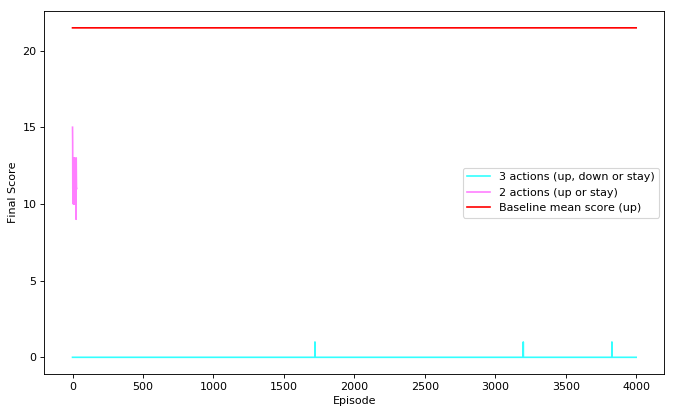

In [38]:
# ---------- Scores of the agent with 2 and 3 actions ----------

baseline = [baseline_mean_score for i in range(4000)]
aux_plots.plot_3scores(scores_3act[:4000], scores_2act[:4000], baseline[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)", "Baseline mean score (up)")

In [40]:
# ---------- Moving average for the scores of the agent with 2 and 3 actions ----------

import statistics 
from statistics import mean

s1 = scores_3act[:4000]
s2 = scores_2act[:4000]
s3 = baseline[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (up, down or stay)", "2 actions (up or stay)", "Baseline mean score (up)")

StatisticsError: mean requires at least one data point

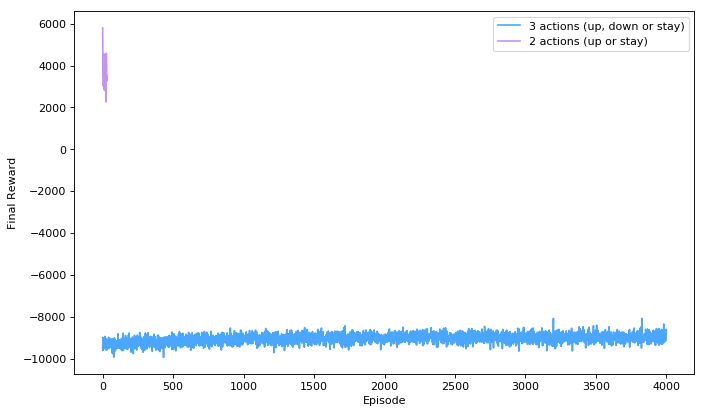

In [41]:
# ---------- Rewards of the agent with 2 and 3 actions ----------

baseline = [baseline_mean_score for i in range(4000)]
aux_plots.plot_2rewards(total_rewards_3act[:4000], total_rewards_2act[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)")

In [ ]:
# ---------- Moving average for the rewards of the agent with 2 and 3 actions ----------

import statistics 

s1 = total_rewards_3act[:4000]
s2 = total_rewards_2act[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_2rewards(s1_avg100, s2_avg100, "3 actions (up, down or stay)", "2 actions (up or stay)")

### 4.2. Influence of the reward values

As we did for the Q-learning agent, in order to investigate the influence of the reward values in the agent behavior also for Monte Carlo control, we ran the algorithm using three different set of reward values.

**R1:** Positive rewards for crossing: it offered a sparse reward to the agent: +1 if the chicken cross all the lanes.

**R2:** Positive rewards for crossing and negative reward for colliding: it given +1 for crossing all the lanes and -1 if the chicken collide. Thus, we expect the agent to be encouraged to cross the lanes (positive reward) and to avoid collisions (negative reward).

**R3:** Huge positive reward for crossing and negative reward for colliding or staying in the same position: it increased the reward for crossing all the lanes to +500 and give -10 when the chicken collide. It also gives a negative reward of -1 when the agent decide to still. Thus we expect the chicken to be incentivate to cross the lanes more rapidilly and increase the score.

#### 4.2.1) Rewards: $+1$ if cross all the lanes

In [ ]:
# # ---------- R1: Crossing the lanes +1 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 1
# reward_policy.REWARD_IF_COLISION = -1
# reward_policy.REWARD_IF_STILL = 0
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [ ]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
#
# scores_2act_sparseR_cross = []
# total_rewards_2act_sparseR_cross = []

In [ ]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#    
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act_sparseR_cross.append(score)
#     total_rewards_2act_sparseR_cross.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act_sparseR_cross, total_reward, score)

In [ ]:
# with open("MC/MC_scores_2act_sparseR_cross.txt", "w") as f:
#    for item in scores_2act_sparseR_cross:
#        f.write("%s\n" % item)
#
# with open("MC/MC_total_rewards_2act_sparseR_cross.txt", "w") as f:
#    for item in total_rewards_2act_sparseR_cross:
#        f.write("%s\n" % item)

In [14]:
with open("MC/MC_scores_2act_sparseR_cross.txt") as f:
   scores_2act_sparseR_cross = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act_sparseR_cross.txt") as f:
   total_rewards_2act_sparseR_cross = [int(x) for x in  f.read().splitlines()]

#### 4.2.2) Rewards: $+1$ if cross all the lanes, $-1$ if collide

In [15]:
# # ---------- R2: Crossing the lanes +1 and colision -1 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5
#
# reward_policy.REWARD_IF_CROSS = 1
# reward_policy.REWARD_IF_COLISION = -1
# reward_policy.REWARD_IF_STILL = 0
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [16]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_2act_sparseR = []
# total_rewards_2act_sparseR = []

In [17]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#    
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act_sparseR.append(score)
#     total_rewards_2act_sparseR.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act_sparseR, total_reward, score)

Run [   0] - Total reward:  -51.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
Run [ 100] - Total reward:  -48.00 Mean scores: 11.88 Means Scores[:-10]: 11.90 Score: 12 
Run [ 200] - Total reward:  -48.00 Mean scores: 12.06 Means Scores[:-10]: 12.30 Score: 12 
Run [ 300] - Total reward:  -48.00 Mean scores: 12.16 Means Scores[:-10]: 12.30 Score: 12 
Run [ 400] - Total reward:  -31.00 Mean scores: 12.34 Means Scores[:-10]: 13.00 Score: 14 
Run [ 500] - Total reward:  -34.00 Mean scores: 12.47 Means Scores[:-10]: 13.10 Score: 13 
Run [ 600] - Total reward:  -39.00 Mean scores: 12.54 Means Scores[:-10]: 12.70 Score: 14 
Run [ 700] - Total reward:  -22.00 Mean scores: 12.60 Means Scores[:-10]: 13.50 Score: 15 
Run [ 800] - Total reward:  -43.00 Mean scores: 12.67 Means Scores[:-10]: 12.90 Score: 13 
Run [ 900] - Total reward:  -31.00 Mean scores: 12.72 Means Scores[:-10]: 13.30 Score: 13 
Run [1000] - Total reward:  -22.00 Mean scores: 12.75 Means Scores[:-10]: 13.10 Score: 14 

In [18]:
# with open("MC/MC_scores_2act_sparseR.txt", "w") as f:
#    for item in scores_2act_sparseR:
#        f.write("%s\n" % item)
#
# with open("MC/MC_total_rewards_2act_sparseR.txt", "w") as f:
#    for item in total_rewards_2act_sparseR:
#        f.write("%s\n" % item)

In [12]:
with open("MC/MC_scores_2act_sparseR.txt") as f:
   scores_2act_sparseR = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act_sparseR.txt") as f:
   total_rewards_2act_sparseR = [int(x) for x in  f.read().splitlines()]

#### 4.2.3) Results got from agents receiving different reward values:

.............................

In [13]:
# ---------- Scores of the agent with different rewards ----------

aux_plots.plot_3scores(scores_2act_sparseR[:4000], scores_2act[:4000], scores_2act_sparseR_cross[:4000], "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

NameError: name 'scores_2act' is not defined

In [ ]:
# ---------- Moving average for the scores of the agent with different rewards ----------

from statistics import mean

s1 = scores_2act_sparseR[:4000]
s2 = scores_2act[:4000]
s3 = scores_2act_sparseR_cross[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

In [ ]:
# ---------- Rewards of the agent with different rewards ----------

aux_plots.plot_3rewards(total_rewards_2act_sparseR[:4000], total_rewards_2act[:4000], scores_2act_sparseR_cross[:4000], "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

In [ ]:
# ---------- Moving average for the total rewards of the agent with different rewards  ----------

from statistics import mean

s1 = total_rewards_2act_sparseR[:4000]
s2 = total_rewards_2act[:4000]
s3 = total_rewards_2act_sparseR_cross[:4000]

blocks = 4000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
        
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s2_avg100.append(value)
        
aux_plots.plot_3rewards(s1_avg100, s2_avg100, s3_avg100, "R1 (+1 if cross)", "R3(+500 if cross, -10 if collide, -1 if stay)", "R2 (+1 if cross, -1 if collide)")

### 4.3. Influence of the $𝑁0$ parameter that is used to define the agent's exploration rate  $\epsilon$

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  
The $𝑁0$ parameter is used to define the agent's exploration rate $\epsilon$ , where  $\epsilon = N0/(N0+n)$ and $n$ is the number of times that state has been visited.  
<br>
As we did for the Q-learning agent, we used a $N0$ value very small (0.001) in order to make our agent short-sighned by only considering immediate rewards, and also used another two values of 2.5 and 5 to compare the results and see how they can impact the agent behavior. 

#### 4.3.1) $N0$ = 0.001

In [ ]:
# # ---------- Agent with N0=0.001 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 =  0.001
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 7000

In [ ]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_2act_N0_0 = []
# total_rewards_2act_N0_0 = []

In [ ]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#    
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act_N0_0.append(score)
#     total_rewards_2act_N0_0.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act_N0_0, total_reward, score)

In [ ]:
# with open("MC/MC_scores_2act_N0_0.txt", "w") as f:
#    for item in scores_2act_N0_0:
#        f.write("%s\n" % item)
#
# with open("MC/MC_total_rewards_2act_N0_0.txt", "w") as f:
#    for item in total_rewards_2act_N0_0:
#        f.write("%s\n" % item)

In [82]:
with open("MC/MC_scores_2act_N0_0.txt") as f:
   scores_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act_N0_0.txt") as f:
   total_rewards_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

# 4.3.2 tá rodando no pc da sala 

#### 4.3.2) $N0$ = 5

In [ ]:
# # ---------- Agent with N0=5 ----------
#
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 =  5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 7000

In [ ]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_2act_N0_5 = []
# total_rewards_2act_N0_5 = []

In [ ]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#    
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act_N0_5.append(score)
#     total_rewards_2act_N0_5.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act_N0_5, total_reward, score)

In [ ]:
# with open("MC/MC_scores_2act_N0_5.txt", "w") as f:
#    for item in scores_2act_N0_5:
#        f.write("%s\n" % item)
#
# with open("MC/MC_total_rewards_2act_N0_5.txt", "w") as f:
#    for item in total_rewards_2act_N0_5:
#        f.write("%s\n" % item)

In [ ]:
with open("MC/MC_scores_2act_N0_5.txt") as f:
   scores_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act_N0_5.txt") as f:
   total_rewards_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

#### 4.3.3) Results got using different $N0$ values:

......................

In [ ]:
# ---------- Scores of the agent with N0=0.001, N0=2.5 and N0=5 ----------

aux_plots.plot_3scores(scores_2act_N0_0[:7000], scores_2act[:7000], scores_2act_N0_5[:7000], "N0=0.001", "N0=2.50", "N0=5.00")

In [ ]:
# ---------- Moving average of the scores of the agent with N0=0.001, N0=2.5 and N0=5 ----------

from statistics import mean

s1 = scores_2act_N0_0[:7000]
s2 = scores_2act[:7000]
s3 = scores_2act_N0_5[:7000]

blocks = 7000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])\n",
    s2_avg100.append(value)"
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])\n",
    s3_avg100.append(value)"
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "N0=0.001", "N0=2.50", "N0=5.00")

In [ ]:
# ---------- Rewards of the agent with N0=0.001, N0=2.5 and N0=5 ----------

aux_plots.plot_3rewards(total_rewards_2act_N0_0[:7000], total_rewards_2act[:7000], total_rewards_2act_N0_5[:7000], "N0=0.001", "N0=2.50", "N0=5.00")

In [ ]:
# ---------- Moving average for the total rewards of the agent with N0=0.001, N0=2.5 and N0=5 ----------

from statistics import mean

s1 = total_rewards_2act_N0_0[:7000]
s2 = total_rewards_2act[:7000]
s3 = total_rewards_2act_N0_5[:7000]

blocks = 7000//100
s1_avg100 = []

for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
        
aux_plots.plot_3rewards(s1_avg100, s2_avg100, s3_avg100, "N0=0.001", "N0=2.50", "N0=5.00")

### 4.4. Influence of the discount factor

#### 4.4.1) - $ɣ$ = 0.90

In [ ]:
# # ---------- Agent with gamma=0.90 ----------
#
# GAMMA = 0.90
# AVAILABLE_ACTIONS = 2
# N0 =  2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [ ]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_2act_gamma_0p9 = []
# total_rewards_2act_gamma_0p9 = []

In [ ]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#   
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act_gamma_0p9.append(score)
#     total_rewards_2act_gamma_0p9.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act_gamma_0p9, total_reward, score)

In [ ]:
# with open("MC/MC_scores_2act_gamma_0p9.txt", "w") as f:
#    for item in scores_2act_gamma_0p9:
#        f.write("%s\n" % item)
#
# with open("MC/MC_total_rewards_2act_gamma_0p9.txt", "w") as f:
#    for item in total_rewards_2act_gamma_0p9:
#        f.write("%s\n" % item)

In [103]:
with open("MC/MC_scores_2act_gamma_0p9.txt") as f:
   scores_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act_gamma_0p9.txt") as f:
   total_rewards_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

#### 4.4.2) - $ɣ$ = 0.75

In [ ]:
# # ---------- Agent with gamma=0.75 ----------
#
# GAMMA = 0.75
# AVAILABLE_ACTIONS = 2
# N0 =  2.5
#
# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 
#
# n_runs = 4000

In [ ]:
# env, initial_state = environment.get_env()
# agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# def MonteCarloES(RAM_mask: List[int], render: bool=False):
#     epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
#     return agent.update_policy(epi)
#
# scores_2act_gamma_0p75 = []
# total_rewards_2act_gamma_0p75 = []

In [ ]:
# %%time
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#    
#     score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)
#
#     scores_2act_gamma_0p75.append(score)
#     total_rewards_2act_gamma_0p75.append(total_reward)
#
#     if i % 100 == 0:
#         print_result(i, scores_2act_gamma_0p75, total_reward, score)

In [ ]:
# with open("MC/MC_scores_2act_gamma_0p75.txt", "w") as f:
#    for item in scores_2act_gamma_0p75:
#        f.write("%s\n" % item)
#
# with open("MC/MC_total_rewards_2act_gamma_0p75.txt", "w") as f:
#    for item in total_rewards_2act_gamma_0p75:
#        f.write("%s\n" % item)

In [104]:
with open("MC/MC_scores_2act_gamma_0p75.txt") as f:
   scores_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

with open("MC/MC_total_rewards_2act_gamma_0p75.txt") as f:
   total_rewards_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

#### 4.4.3) Results got using different $\gamma$ values:

......................

In [ ]:
# ---------- Scores of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

aux_plots.plot_3scores(scores_2act_gamma_0p9[:4000], scores_2act[:4000], scores_2act_gamma_0p75[:4000], "gamma=0.90", "gamma=0.99", "gamma=0.75")

In [ ]:
# ---------- Moving average for the scores of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

s1 = scores_2act_gamma_0p9[:4000]
s2 = scores_2act[:4000]
s3 = scores_2act_gamma_0p75[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "gamma=0.90", "gamma=0.99", "gamma=0.75")

In [ ]:
# ---------- Total rewards of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

aux_plots.plot_3rewards(total_rewards_2act_gamma_0p9[:4000], total_rewards_2act[:4000], total_rewards_2act_gamma_0p75[:4000], "gamma=0.90", "gamma=0.99", "gamma=0.75")

In [ ]:
# ---------- Moving average for the total rewards of the agent with gamma=0.99 gamma=0.90 and gamma=0.75 ---------

s1 = total_rewards_2act_gamma_0p9[:4000]
s2 = total_rewards_2act[:4000]
s3 = total_rewards_2act_gamma_0p75[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3rewards(s1_avg100, s2_avg100, s3_avg100, "gamma=0.90", "gamma=0.99", "gamma=0.75")

## 5) Sarsa($\lambda$)

## 6) Function aproximator